## Example code to illustrate the API for cNMF on simulated data

 - Current as of October 23 2019
 - Email dkotliar@broadinstitute.org with questions

## The code below by default does not use any parallelization but provides example commands for using parallel or a UGER scheduler for running the factorization in parallel

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib import gridspec

## Download the example data from the web

In [3]:
! wget -O ./example_simulated_data.tar.gz https://storage.googleapis.com/sabeti-public/dkotliar/cNMF/example_data_20191024.tar.gz
! tar -zxvf ./example_simulated_data.tar.gz && rm ./example_simulated_data.tar.gz

--2019-10-28 16:43:46--  https://storage.googleapis.com/sabeti-public/dkotliar/cNMF/example_data_20191024.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8115726 (7.7M) [application/gzip]
Saving to: ‘./example_simulated_data.tar.gz’

./example_simulated 100%[===================>]   7.74M  --.-KB/s    in 0.1s    

2019-10-28 16:43:46 (75.5 MB/s) - ‘./example_simulated_data.tar.gz’ saved [8115726/8115726]

./simulated_example_data/counts.npz
./simulated_example_data/filtered_counts.txt
./simulated_example_data/groundtruth_cellparams.txt
./simulated_example_data/groundtruth_geneparams.txt
./simulated_example_data/tsne.txt


## cNMF run parameters

In [4]:
numiter=20 ## Set this to a larger value for real data. We set this to a low value here for illustration
numworkers=1 ## Set this to a larger value and use the parallel code cells to try out parallelization
numhvgenes=1500 ## Number of over-dispersed genes to use for running the factorizations
K = ' '.join([str(i) for i in range(5,10)])

## Results will be saved to [output_directory]/[run_name] which in this example is simulated_example_data/example_cNMF
output_directory = './simulated_example_data'
run_name = 'example_cNMF'

countfn = './simulated_example_data/filtered_counts.txt'
seed = 14

In [5]:
print(K)

5 6 7 8 9


## Prepare the normalized count matrix of highvar genes and the cNMF parameters file assuming no parallelization
 - This will normalize the counts matrix and select the 2000 most over-dispersed genes for running cNMF on.
 - It indicates that it will run 5 NMF iterations each for K=4, 5, 6, 7, and 8. With one worker

In [6]:
prepare_cmd = 'python ../cnmf.py prepare --output-dir %s --name %s -c %s -k %s --n-iter %d --total-workers %d --seed %d --numgenes %d' % (output_directory, run_name, countfn, K, numiter, numworkers, seed, numhvgenes)
print('Prepare command:\n%s' % prepare_cmd)
! {prepare_cmd}

Prepare command:
python ../cnmf.py prepare --output-dir ./simulated_example_data --name example_cNMF -c ./simulated_example_data/filtered_counts.txt -k 5 6 7 8 9 --n-iter 20 --total-workers 1 --seed 14 --numgenes 1500
/opt/miniconda3/envs/cnmf_env/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Run the factorization step of cNMF without any parallelization

This might take a few minutes to a half hour depending on how many cores there are on your machine.  You can lower the number of iterations or the K values being considered to speed this up.

As some more explanation, all of the factorization tasks were allocated in the prepare step above to a single worker (worker # 0). We are now executing the factorization steps for that single worker.

In our testing, this took less than a minute to run

In [7]:
factorize_cmd = 'python ../cnmf.py factorize --output-dir %s --name %s --worker-index 0' % (output_directory, run_name)
print('Factorize command for worker 0:\n%s' % factorize_cmd)
! {factorize_cmd}

Factorize command for worker 0:
python ../cnmf.py factorize --output-dir ./simulated_example_data --name example_cNMF --worker-index 0
[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
[Worker 0]. Starting task 20.
[Worker 0]. Starting task 21.
[Worker 0]. Starting task 22.
[Worker 0]. Starting task 23.
[Worker 0]. Starting task 24.
[Worker 0]. Starting task 25.
[Worker 0]. Starting task 26.
[Worker 0]. Starting task 27.
[Worker 0]. Starting task 28.
[Work

## Run replicates of cNMF for multiple K values in parallel

If more than one total worker is specified, we would need to allocate the tasks for each worker to a distinct processor to work in parallel. There are many ways to do that depending on your compute infastructure.

Here we provide example commands for how you would run the factorization step for cNMF using GNU parallel or UGER if you allocated the tasks amongst 5 workers. First you would need to run the prepare step to specify 5 total workers like below

In [8]:
numiter=5 ## Set this to a larger value for real data. We set this to a low value here for illustration
parallelize_numworkers=5 ## This will parallelize the jobs over 5 workers
numhvgenes=2000
run_name = 'example_cNMF'
K = ' '.join([str(i) for i in range(4,9)])
output_directory = './simulated_example_data'
countfn = './simulated_example_data/filtered_counts.txt'
seed = 14

prepare_cmd = 'python ../cnmf.py prepare --output-dir %s --name %s -c %s -k %s --n-iter %d --total-workers %d --seed %d --numgenes %d' % (output_directory, run_name, countfn, K, numiter, parallelize_numworkers, seed, numhvgenes)
print('Prepare command allocating 5 workers:\n%s' % prepare_cmd)
#! {prepare_cmd}

Prepare command allocating 5 workers:
python ../cnmf.py prepare --output-dir ./simulated_example_data --name example_cNMF -c ./simulated_example_data/filtered_counts.txt -k 4 5 6 7 8 --n-iter 5 --total-workers 5 --seed 14 --numgenes 2000


Then you could use submission commands such as those specified below

In [9]:
## Using GNU parallel
worker_index = ' '.join([str(x) for x in range(parallelize_numworkers)])
cmd = 'nohup parallel python ../cnmf.py factorize --output-dir %s --name %s --worker-index {} ::: %s' % (output_directory, run_name, worker_index)
print(cmd)
#!{cmd}

nohup parallel python ../cnmf.py factorize --output-dir ./simulated_example_data --name example_cNMF --worker-index {} ::: 0 1 2 3 4


In [10]:
## Using UGER
logdir = './log'
cmd = "qsub -cwd -b y -l h_vmem=2g,h_rt=3:00:00 -o %s -e %s -N cnmf -t 1-%d 'python ../cnmf.py factorize --output-dir %s --name %s --worker-index $SGE_TASK_ID'" % (logdir, logdir, parallelize_numworkers, output_directory, run_name)
print(cmd)
#!{cmd}

qsub -cwd -b y -l h_vmem=2g,h_rt=3:00:00 -o ./log -e ./log -N cnmf -t 1-5 'python ../cnmf.py factorize --output-dir ./simulated_example_data --name example_cNMF --worker-index $SGE_TASK_ID'


## Combine the replicate spectra into merged spectra files

Now that the individual factorization replicates have been run, we need to combine them into a single file for each value of K tested

In [11]:
cmd = 'python ../cnmf.py combine --output-dir %s --name %s' % (output_directory, run_name)
print('Combine command:\n%s' % cmd)
!{cmd}

Combine command:
python ../cnmf.py combine --output-dir ./simulated_example_data --name example_cNMF
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.


## Plot the trade-off between error and stability as a function of K to guide selection of K 

There is no perfect way to choose the value of K for cNMF or for any matrix factorization or clustering algorithm. One approach that can be helpful is to plot the trade-off between solution stability and solution error. We can plot that with the command below

In [12]:
plot_K_selection_cmd = 'python ../cnmf.py k_selection_plot --output-dir %s --name %s' % (output_directory, run_name)
print('Plot K tradeoff command:\n%s' % plot_K_selection_cmd)
!{plot_K_selection_cmd}

Plot K tradeoff command:
python ../cnmf.py k_selection_plot --output-dir ./simulated_example_data --name example_cNMF


### The plot was just saved to ./simulated_example_data/example_cNMF/example_cNMF.k_selection.pdf

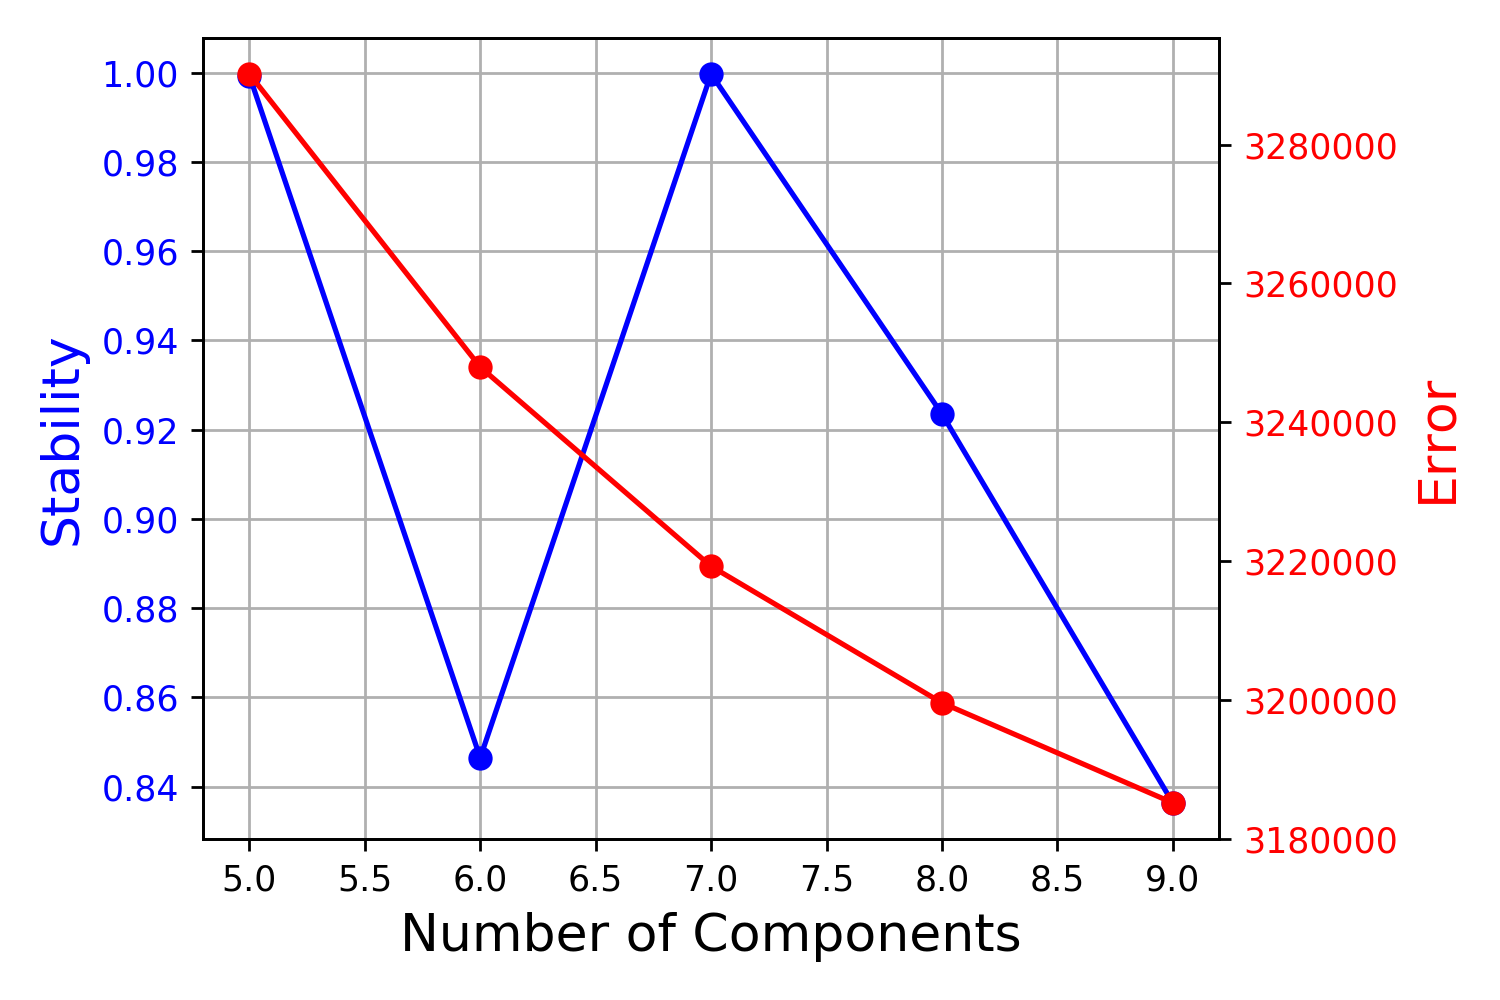

In [13]:
Image(filename = "./simulated_example_data/example_cNMF/example_cNMF.k_selection.png", width=1000, height=1000)


Based on the above plot, we would be interested in investigating Ks around K=7 as a starting point as these are values where the stability has plateaued.

## We proceed to obtain the consensus matrix factorization estimates

We first look at how the results look without filtering and then set a threshold for filtering outliers based on the consensus clustergram

In [14]:
selected_K = 7

In [15]:
## This is the command you would run from the command line to obtain the consensus estimate with no filtering
## and to save a diagnostic plot as a PDF
consensus_cmd = 'python ../cnmf.py consensus --output-dir %s --name %s --local-density-threshold %.2f --components %d --show-clustering' % (output_directory, run_name, 2.00, selected_K)
print('Consensus command for K=%d:\n%s' % (selected_K, consensus_cmd))
!{consensus_cmd}

Consensus command for K=7:
python ../cnmf.py consensus --output-dir ./simulated_example_data --name example_cNMF --local-density-threshold 2.00 --components 7 --show-clustering


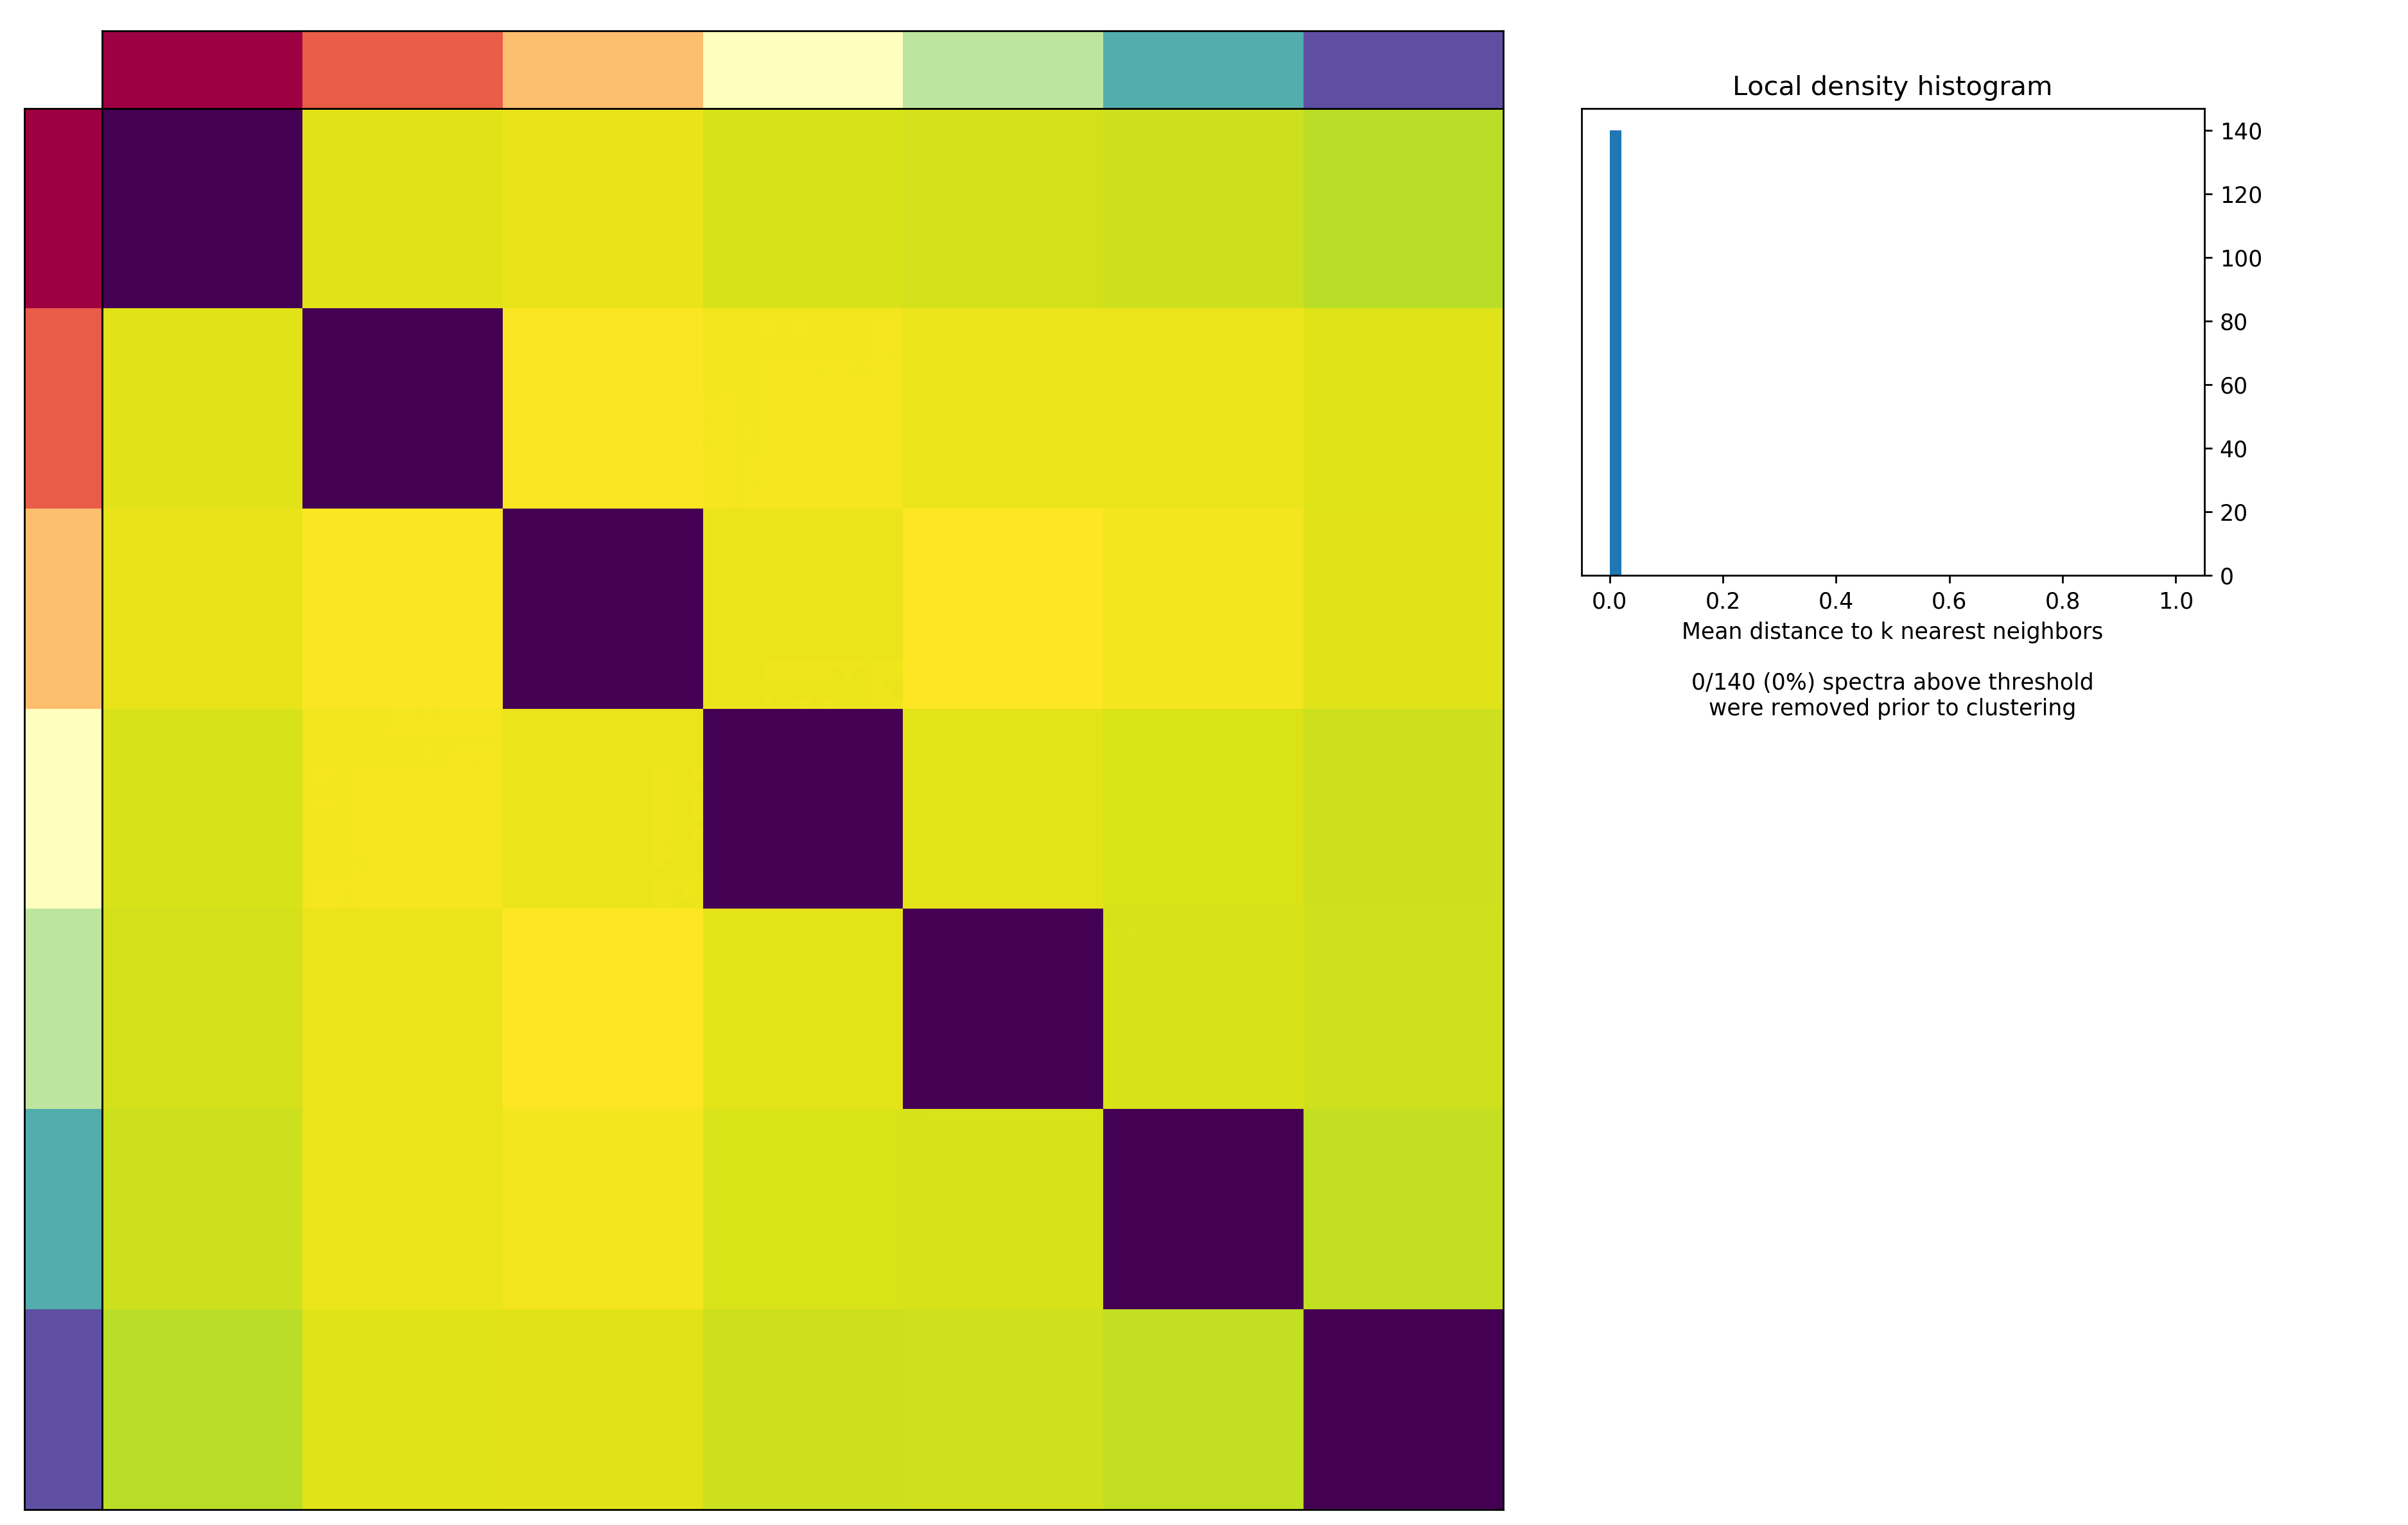

In [16]:
from IPython.display import Image
Image(filename = "./simulated_example_data/example_cNMF/example_cNMF.clustering.k_%d.dt_2_00.png" % selected_K, width=1000, height=1000)


This looks reasonable. We are finding 7 clusters as expected. There are some noisey outlier components that we want to filter before clustering. Setting a threshold of 0.1 should filter those out.

In [17]:
density_threshold = 0.10
density_threshold_str = '0_10'

In [18]:
consensus_cmd = 'python ../cnmf.py consensus --output-dir %s --name %s --local-density-threshold %.2f --components %d --show-clustering' % (output_directory, run_name,density_threshold, selected_K)
print('Command: %s' % consensus_cmd)
!{consensus_cmd}

Command: python ../cnmf.py consensus --output-dir ./simulated_example_data --name example_cNMF --local-density-threshold 0.10 --components 7 --show-clustering


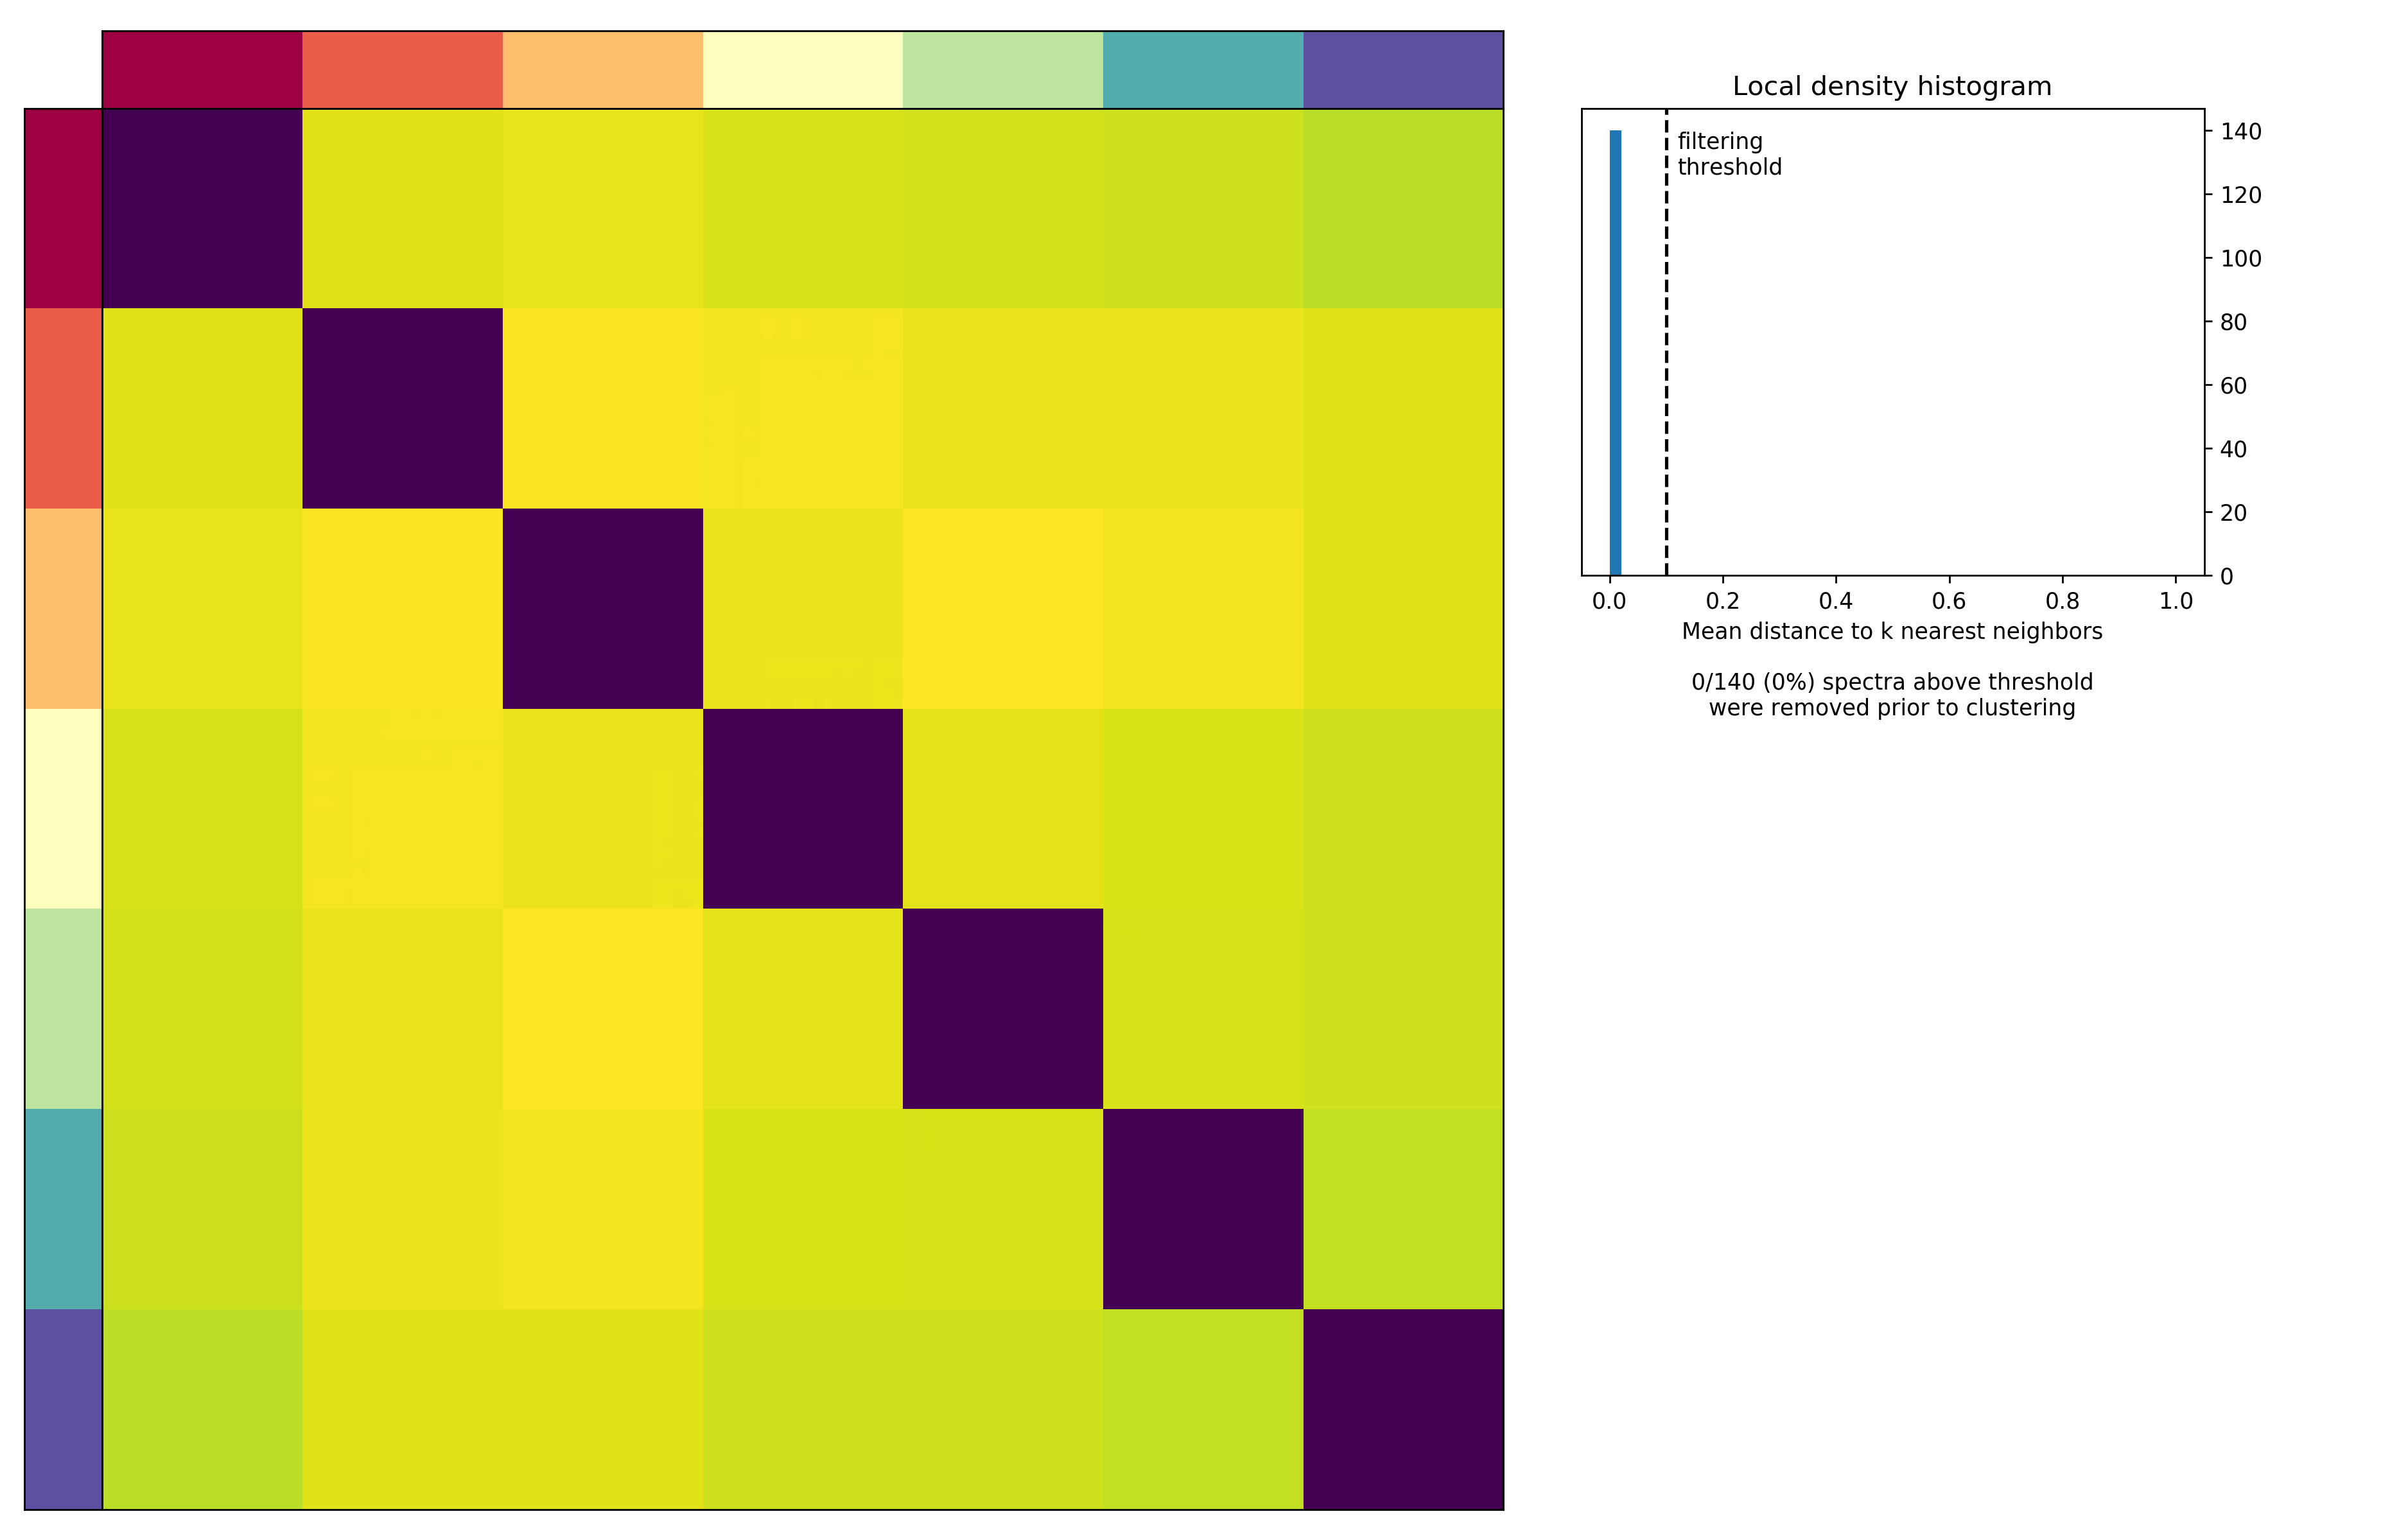

In [19]:
from IPython.display import Image
Image(filename = "./simulated_example_data/example_cNMF/example_cNMF.clustering.k_%d.dt_%s.png" % (selected_K, density_threshold_str), width=1000, height=1000)


In [20]:
! ls simulated_example_data/example_cNMF

cnmf_tmp
example_cNMF.clustering.k_7.dt_0_10.png
example_cNMF.clustering.k_7.dt_2_00.png
example_cNMF.gene_spectra_score.k_7.dt_0_10.txt
example_cNMF.gene_spectra_score.k_7.dt_2_00.txt
example_cNMF.gene_spectra_tpm.k_7.dt_0_10.txt
example_cNMF.gene_spectra_tpm.k_7.dt_2_00.txt
example_cNMF.k_selection.png
example_cNMF.k_selection_stats.df.npz
example_cNMF.overdispersed_genes.txt
example_cNMF.spectra.k_7.dt_0_10.consensus.txt
example_cNMF.spectra.k_7.dt_2_00.consensus.txt
example_cNMF.usages.k_7.dt_0_10.consensus.txt
example_cNMF.usages.k_7.dt_2_00.consensus.txt


### Our intended final results files are:

 - example_cNMF.gene_spectra_score.k_6.dt_0_40.txt
 - example_cNMF.gene_spectra_tpm.k_6.dt_0_40.txt
 - example_cNMF.usages.k_6.dt_0_40.consensus.txt
 
The first 2 contain the GEPs re-fit to all of the genes either in units of tpm (example_cNMF.gene_spectra_tpm.k_6.dt_0_40.txt) or in Z-score units (example_cNMF.gene_spectra_score.k_6.dt_0_40.txt). The usage matrix is (example_cNMF.usages.k_6.dt_0_40.consensus.txt)

## Now lets make a few plots to illustrate the results

### Run PCA on high-var genes TPM normalized

This step can be skipped if you want to just load the pre-generated tsne results in ./simulated_example_data/tsne.txt

### Plot the ground truth as well as the cNMF inferences on a tSNE plot

In [21]:
usage_matrix = pd.read_csv('./simulated_example_data/example_cNMF/example_cNMF.usages.k_%d.dt_%s.consensus.txt' % (selected_K, density_threshold_str), sep='\t', index_col=0)
usage_matrix.columns = np.arange(1,selected_K+1)
normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
normalized_usage_matrix.head()

,1,2,3,4,5,6,7
index,,,,,,,
Cell1,0.076214,0.010609,0.109580,0.002126,0.000000,0.758381,0.043090
Cell2,0.775942,0.075645,0.122049,0.013591,0.000000,0.012772,0.000000
Cell3,0.046293,0.000000,0.065061,0.052736,0.026435,0.000000,0.809475
Cell4,0.000000,0.507998,0.330577,0.000000,0.029369,0.031404,0.100652
Cell5,0.129811,0.081653,0.254852,0.089929,0.388093,0.029616,0.026046


In [22]:
tsne_results = pd.read_csv('./simulated_example_data/tsne.txt', sep='\t', index_col=0)
tsne_results.head()

,TSNE1,TSNE2
Cell1,-26.829270,-12.981769
Cell2,5.473053,22.799021
Cell3,-22.220153,11.276251
Cell4,29.347240,3.582170
Cell5,9.972195,-1.723736


In [23]:
import palettable
from matplotlib import rcParams
from collections import Counter

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Myriad Pro']

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

rcParams['xtick.major.pad']='1'
rcParams['ytick.major.pad']='1'

import matplotlib as mpl
label_size = 8

core_colors = type('CoreColors', (), {})

cnames = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'brown', 'pink', 'grey']

def to_array_col(color):
    return np.array(color)/255.

for cname,c in zip(cnames, palettable.colorbrewer.qualitative.Set1_9.colors):
    setattr(core_colors, cname, np.array(c)/255.)
    
for cname, c in zip(['blue', 'green', 'red', 'orange', 'purple'],
                    palettable.colorbrewer.qualitative.Paired_10.colors[::2]):
    setattr(core_colors, 'pale_'+cname, np.array(c)/255.)
    
core_colors.teal = to_array_col(palettable.colorbrewer.qualitative.Set2_3.colors[0])
core_colors.brown_red = to_array_col(palettable.colorbrewer.qualitative.Dark2_3.colors[1])

# core_colors.light_grey = to_array_col(palettable.colorbrewer.qualitative.Set2_8.colors[-1])
core_colors.light_grey = to_array_col(palettable.tableau.TableauLight_10.colors[7])

core_colors.royal_green = to_array_col(palettable.wesanderson.Royal1_4.colors[0])


In [24]:
celldata = pd.read_csv('./simulated_example_data/groundtruth_cellparams.txt', sep='\t', index_col=0)
celldata.head()

,group,libsize,has_program,program_usage,is_doublet,group2
Cell1,4,2623.118236,False,0.000000,False,-1
Cell2,5,1623.833614,False,0.000000,False,-1
Cell3,6,2222.490202,False,0.000000,False,-1
Cell4,1,3213.596131,True,0.262699,False,-1
Cell5,2,2396.513589,True,0.127641,False,-1


In [25]:
tsnedat = pd.merge(left=tsne_results, right=celldata, left_index=True, right_index=True)

tsnedat['extra-status'] = 'Normal'
tsnedat.loc[tsnedat['has_program'] & ~tsnedat['is_doublet'], 'extra-status'] = 'program'
tsnedat.loc[~tsnedat['has_program'] & tsnedat['is_doublet'], 'extra-status'] = 'doublet'
tsnedat.loc[ tsnedat['has_program'] & tsnedat['is_doublet'], 'extra-status'] = 'program & doublet'

In [26]:
cell_tableau10_color_id = tsnedat['group'].astype(int).values - 1
cell_tableau10_color = np.array(palettable.tableau.Tableau_10.colors[:-1])[cell_tableau10_color_id]/255.

activity_color = np.zeros((tsnedat.shape[0], 4))
activity_color[:, 3] = tsnedat['has_program'].astype(float)
doublet_color = np.array(palettable.tableau.TableauMedium_10.colors[5])/255. 

In [27]:
normal_filter = tsnedat['extra-status'] == 'Normal'
doublet_filter = tsnedat['extra-status'] == 'doublet'
activity_filter = tsnedat['extra-status'] == 'program'
activity_and_doublet_filter = tsnedat['extra-status'] == 'program & doublet'

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(0, 1)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


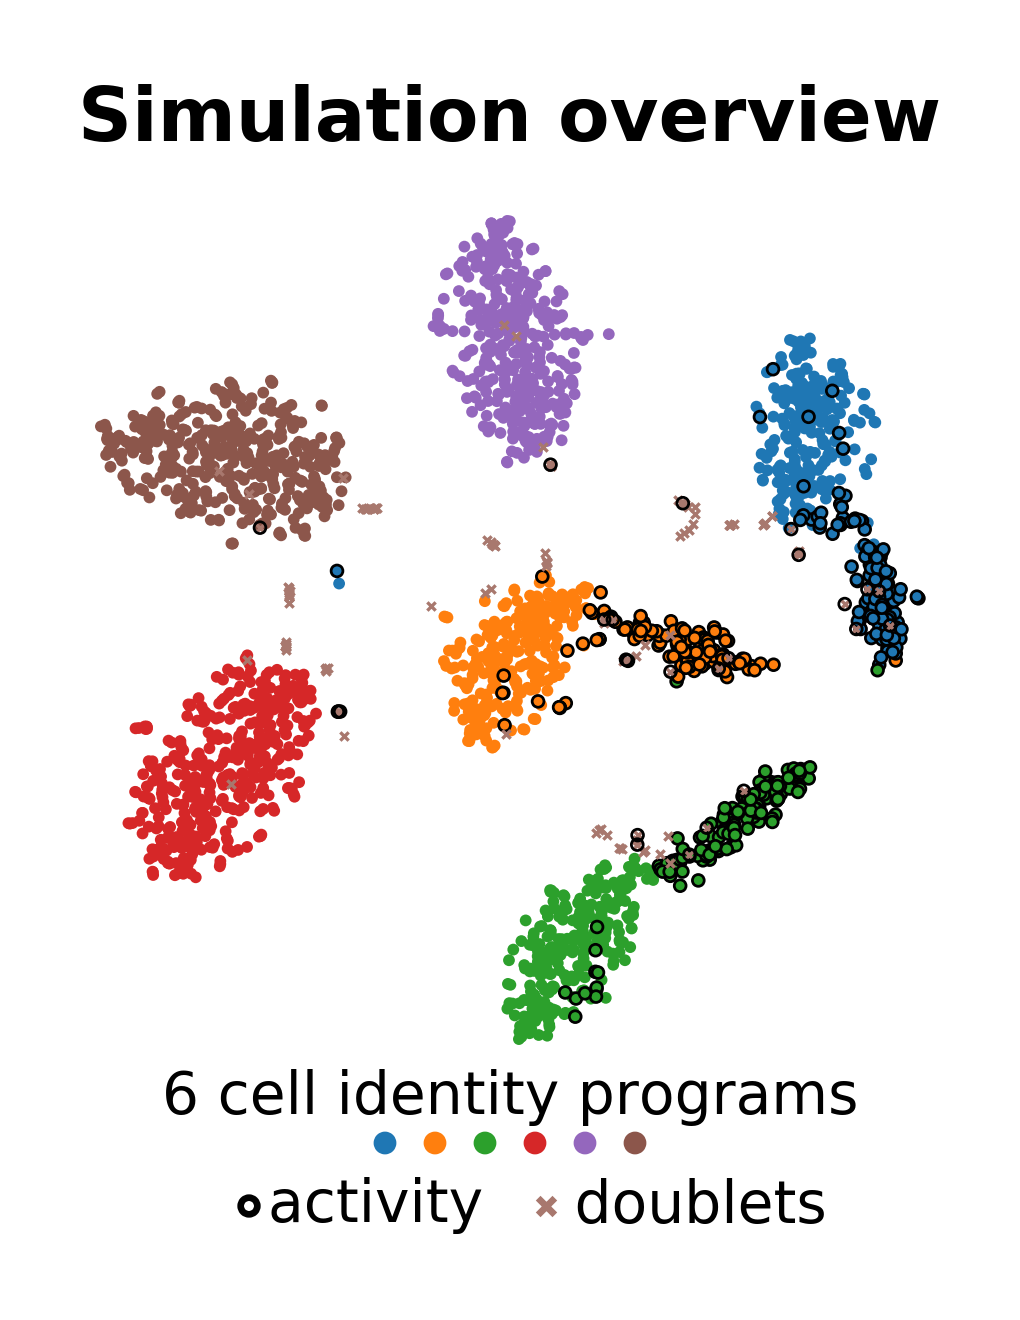

In [28]:
identityK = 6
fig = plt.figure(figsize=(1.5, 2), dpi=600)
gs = gridspec.GridSpec(3, 1, fig, 0,0,1,1,
                       hspace=0, wspace=0,
                       height_ratios=[0.2, 1.5, 0.3],
                       width_ratios=[1])

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=False, xticks=[], yticks=[])

x = tsnedat['TSNE1']
y = tsnedat['TSNE2']


curr_filter = normal_filter


ax.scatter(x[curr_filter], y[curr_filter],
          facecolor=cell_tableau10_color[curr_filter.values],
           edgecolor='none',
           rasterized=True, s=2)

curr_filter = activity_filter
ax.scatter(x[curr_filter], y[curr_filter],
          facecolor=cell_tableau10_color[curr_filter.values],
          edgecolor=activity_color[curr_filter.values], linewidth=0.33,
           rasterized=False, s=2)


curr_filter = doublet_filter | activity_and_doublet_filter
ax.scatter(x[curr_filter], y[curr_filter],
          c=doublet_color,
          edgecolor='none', marker='x', linewidth=0.4,
          s=1)

curr_filter = activity_and_doublet_filter
ax.scatter(x[curr_filter], y[curr_filter],
          facecolor='none',
          edgecolor=activity_color[curr_filter.values], linewidth=0.33,
           rasterized=False, s=2)


ax = fig.add_subplot(gs[0, 0],
          frameon=False, xticks=[], yticks=[], xlim=[0,1], ylim=[0,1])

ax.text(0.50, 0.5, 'Simulation overview', va='center', ha='center', fontsize=9, fontdict=dict(weight='bold'),
        clip_on=False)


ax = fig.add_subplot(gs[2, 0],
          frameon=False, xticks=[], yticks=[], xlim=[0,1], ylim=[0,1])

ax.text(0.50, 0.9, '%d cell identity programs' % identityK, va='center', ha='center', fontsize=7,
        clip_on=False)

leg_x = np.arange(identityK)/18
leg_x -= leg_x.mean()
leg_x += 0.5

ax.scatter(leg_x, np.ones(identityK)*0.65, c=np.array(palettable.tableau.Tableau_10.colors[:identityK])/255, s=3)



activity_y = 0.30
ax.text(0.33, activity_y, '  activity', verticalalignment='center', ha='center', fontsize=7,
        clip_on=False)

ax.scatter([0.21], [activity_y], 
           facecolor='none', edgecolor='k', linewidth=0.8, s=4)


doub_y = activity_y
ax.text(0.66, doub_y, '     doublets', verticalalignment='center', ha='center', fontsize=7,
        clip_on=False)

ax.scatter([0.54], [doub_y], c=[doublet_color],
           edgecolor='none', marker='x', linewidth=0.8, s=4, clip_on=False)

ax.set_xlim([0,1])
ax.set_ylim([0,1])

In [29]:
tsne_and_usages = pd.merge(left=normalized_usage_matrix, right=tsne_results, left_index=True, right_index=True)
tsne_and_usages.head()

,1,2,3,4,5,6,7,TSNE1,TSNE2
Cell1,0.076214,0.010609,0.109580,0.002126,0.000000,0.758381,0.043090,-26.829270,-12.981769
Cell2,0.775942,0.075645,0.122049,0.013591,0.000000,0.012772,0.000000,5.473053,22.799021
Cell3,0.046293,0.000000,0.065061,0.052736,0.026435,0.000000,0.809475,-22.220153,11.276251
Cell4,0.000000,0.507998,0.330577,0.000000,0.029369,0.031404,0.100652,29.347240,3.582170
Cell5,0.129811,0.081653,0.254852,0.089929,0.388093,0.029616,0.026046,9.972195,-1.723736


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


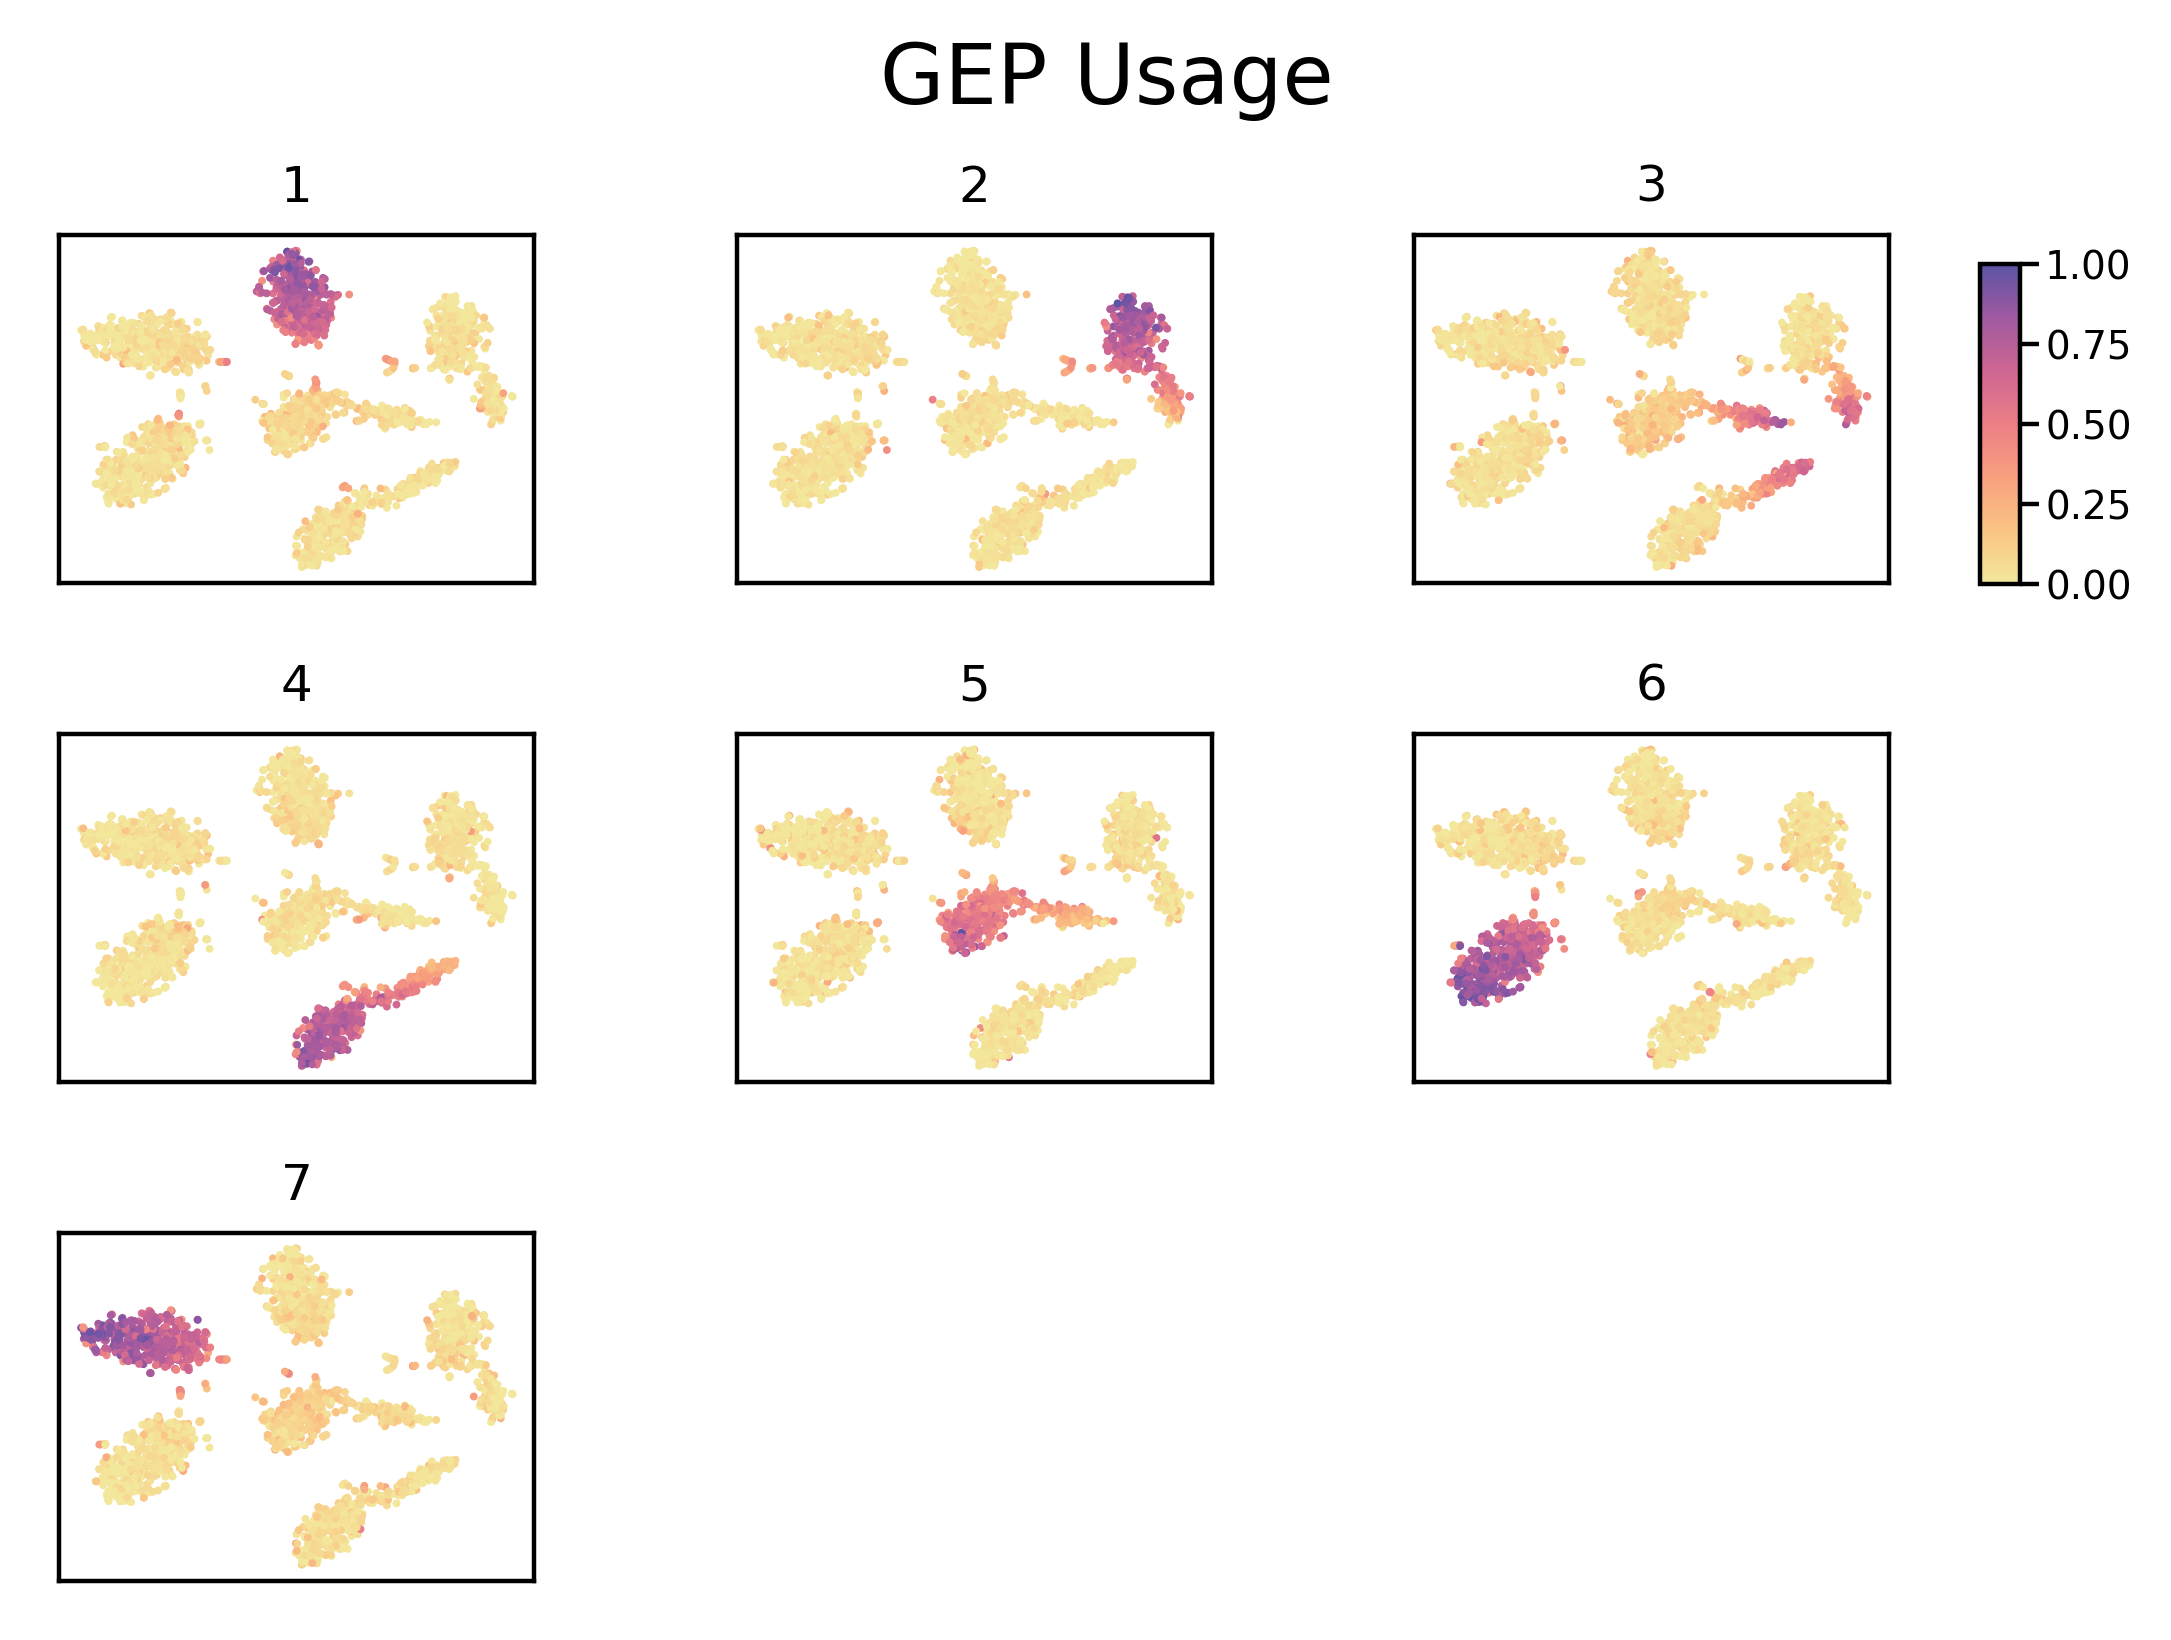

In [30]:
cmap = palettable.cartocolors.sequential.Sunset_7.get_mpl_colormap()

(fig,axes) = plt.subplots(3,3, figsize=(5,4), dpi=400)
axes = axes.ravel()
for i in range(1, selected_K+1):
    sc = axes[i-1].scatter(tsne_and_usages['TSNE1'], tsne_and_usages['TSNE2'], c=tsne_and_usages[i],
                      cmap=cmap, vmin=0, vmax=1.,
                      s=2, edgecolor='none', rasterized=True)
    axes[i-1].set_title(i)
    axes[i-1].set_xticks([])
    axes[i-1].set_yticks([])
    
    
    
plt.tight_layout()
cbarax = fig.add_axes([1,.7,.02, .2])
plt.colorbar(sc, cax=cbarax)
_ = plt.figtext(.45,1,'GEP Usage', fontsize=15)
axes[-1].remove()
axes[-2].remove()

The plot above shows which cells are expressing which programs. The first program is distributed over cells of multiple identity programs and therefore corresponds to the activity program. GEP 2-6 correspond to distinct identity programs

We might also want to investigate which genes are driving which programs. We can do so by loading the Z-score transformed spectra and sorting it as follows

In [31]:
gene_scores = pd.read_csv('./simulated_example_data/example_cNMF/example_cNMF.gene_spectra_score.k_%d.dt_%s.txt' % (selected_K, density_threshold_str), sep='\t', index_col=0)
gene_scores = gene_scores.T
gene_scores.head()

,1,2,3,4,5,6,7
Gene1,-0.000045,-0.000057,-0.000187,0.000730,-0.000026,-0.000225,-1.764578e-04
Gene2,0.000151,-0.000020,0.000042,-0.000036,-0.000048,0.000099,-1.026845e-06
Gene3,-0.000091,-0.000073,-0.000012,0.000235,-0.000032,-0.000101,9.044247e-07
Gene5,-0.000026,0.000010,0.000036,-0.000086,0.000002,-0.000106,5.101629e-05
Gene6,0.000008,0.000028,0.000010,0.000051,-0.000074,0.000022,-3.749202e-05


In [32]:
topgenes = []
num_top_genes=10
for gep in gene_scores.columns:
    topgenes.append(pd.Series(gene_scores[gep].sort_values(ascending=False).index[:num_top_genes]))
    
topgenes = pd.concat(topgenes, axis=1)
topgenes.columns = gene_scores.columns

In [33]:
topgenes

,1,2,3,4,5,6,7
0,Gene8378,Gene6144,Gene9938,Gene9445,Gene8555,Gene2342,Gene6757
1,Gene7654,Gene610,Gene9639,Gene5098,Gene6335,Gene2634,Gene72
2,Gene263,Gene8402,Gene9730,Gene8394,Gene1448,Gene5050,Gene1643
3,Gene8614,Gene7378,Gene9953,Gene6691,Gene3488,Gene8933,Gene7907
4,Gene6950,Gene5024,Gene9682,Gene1053,Gene6732,Gene6244,Gene1091
5,Gene7600,Gene5987,Gene9636,Gene47,Gene2044,Gene2086,Gene5983
6,Gene944,Gene9540,Gene9683,Gene2582,Gene930,Gene4462,Gene2551
7,Gene4364,Gene8511,Gene9767,Gene4666,Gene2806,Gene498,Gene7361
8,Gene324,Gene3287,Gene9699,Gene6395,Gene3052,Gene8960,Gene5686
9,Gene1393,Gene7406,Gene9873,Gene4151,Gene2556,Gene8507,Gene6936


## The above shows the top 10 genes associated with each gene expression program (columns)